In [1]:
import khmer
# ref = https://github.com/dib-lab/khmer/blob/master/examples/python-api/exact-counting.py
import tqdm
import pandas as pd
import numpy as np
import os
import scanpy.api as sc
import anndata as ad
from scipy import sparse
from plotnine import *
import plotnine
from IPython.core.display import HTML


def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [2]:
# create markers
# cat gencode.v32.transcripts_nolinebreaks_headered.fa | grep -A1 --no-group-separator "TLR" > ../markers.fa

In [3]:
dir_path = '/home/ubuntu/data/longread/'
ksize = 8
nkmers = 4**ksize
fn = 'markers.fa'

# setup results array
entry_len = int(file_len(f'{dir_path}{fn}')/2)

cell_df = pd.DataFrame()
master_df = pd.DataFrame()
kmer_arr = np.zeros((nkmers, entry_len))

seq_id_arr = np.zeros((entry_len), dtype = 'object')
cell_id_arr = np.zeros((entry_len), dtype = 'object')

arr_idx = 0

# ingest all .fa files from dir
for fn in ['markers.fa']:
    if fn.endswith('.fa'):
    
        # extract fn prefix for cell id
        cell_id = fn.split('.fa')[0]

        # read .fa
        with open(f'{dir_path}{fn}', 'r') as f:
            
            # parse entry by entry
            for count, line in tqdm.tqdm(enumerate(f, start=0)):

                
                # extract first line as seq id
                if count % 2 == 0:
                    k_name = line[1:-1]

                # extract second line as sequence
                if count % 2 != 0:

                    # Initialize countgraph
                    tablesize = nkmers + 10
                    ktable = khmer.Countgraph(ksize, tablesize, 1)

                    # count all k-mers in the given string
                    ktable.consume(line[:-1])

                    # capture full kmer counts
                    k_n_list = [ktable.get(i) for i in range(nkmers)]

                    # update kmer count arr
                    kmer_arr[:,arr_idx] = k_n_list 

                    # log sequence and cell names for metadata
                    seq_id_arr[arr_idx] = k_name
                    cell_id_arr[arr_idx] = cell_id

                    # update arr pointer
                    arr_idx = arr_idx + 1

# create dfs
kmers_list = [ktable.reverse_hash(i) for i in range(nkmers)]
master_df = pd.DataFrame(kmer_arr)
master_df['kmers'] = kmers_list
master_df = master_df.set_index('kmers')
master_df.columns = seq_id_arr.tolist()
cell_df = pd.DataFrame({'seq_id':seq_id_arr,
                        'cell_id':cell_id_arr,
                       })
cell_df = cell_df.set_index('seq_id')


80it [00:00, 141.45it/s]


In [21]:
dir_path = '/home/ubuntu/data/longread/'
ksize = 5
nkmers = 4**ksize

entry_len_list = []
for fn in os.listdir(dir_path):
    if fn.endswith('.fa') and fn != 'markers.fa':
        entry_len_list = entry_len_list+[int(file_len(f'{dir_path}{fn}')/2)]

entry_len_sum = int(np.sum(entry_len_list))
min_entry_len = int(np.min(entry_len_list))
balanced_entry_len_sum = int(min_entry_len*len(entry_len_list))

cell_df = pd.DataFrame()
master_df = pd.DataFrame()
kmer_arr = np.zeros((nkmers, balanced_entry_len_sum))

arr_idx = 0
seq_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')
cell_id_arr = np.zeros((balanced_entry_len_sum), dtype = 'object')

# ingest all .fa files from dir
for fn in os.listdir(dir_path):
    if fn.endswith('.fa') and fn != 'markers.fa':
    
        # extract fn prefix for cell id
        cell_id = fn.split('.fa')[0]

        # read .fa
        with open(f'{dir_path}{fn}', 'r') as f:

            # random downsample to smallest fn
            for i, l in enumerate(f):
                pass
            
            entry_len = int((i+1)/2)
            entry_white_list = np.random.choice([x*2 for x in range(entry_len)], 
                                                min_entry_len,
                                                replace = False
                                               ).tolist()
            entry_white_list = [x+1 for x in entry_white_list]+entry_white_list

        with open(f'{dir_path}{fn}', 'r') as f:
            
            # parse entry by entry
            for count, line in tqdm.tqdm(enumerate(f, start=0)):

                # filter on whitelist
                if count in entry_white_list:

                    # extract first line as seq id
                    if count % 2 == 0:
                        k_name = line[1:-1]

                    # extract second line as sequence
                    if count % 2 != 0:

                        # Initialize countgraph
                        tablesize = nkmers + 10
                        ktable = khmer.Countgraph(ksize, tablesize, 1)

                        # count all k-mers in the given string
                        ktable.consume(line[:-1])

                        # capture full kmer counts
                        k_n_list = [ktable.get(i) for i in range(nkmers)]

                        # update kmer count arr
                        kmer_arr[:,arr_idx] = k_n_list 

                        # log sequence and cell names for metadata
                        seq_id_arr[arr_idx] = k_name
                        cell_id_arr[arr_idx] = cell_id

                        # update arr pointer
                        arr_idx = arr_idx + 1

# create dfs
kmers_list = [ktable.reverse_hash(i) for i in range(nkmers)]
master_df = pd.DataFrame(kmer_arr)
master_df['kmers'] = kmers_list
master_df = master_df.set_index('kmers')
master_df.columns = seq_id_arr.tolist()
cell_df = pd.DataFrame({'seq_id':seq_id_arr,
                        'cell_id':cell_id_arr,
                       })
cell_df = cell_df.set_index('seq_id')


3326it [00:00, 5385.79it/s]
11746it [00:01, 10099.73it/s]
34966it [00:02, 12905.94it/s]
9786it [00:01, 8921.23it/s]
10186it [00:01, 9665.65it/s]
7562it [00:00, 8452.77it/s]
4412it [00:00, 6347.66it/s]
3540it [00:00, 5893.41it/s]
12092it [00:01, 10019.19it/s]
6410it [00:00, 7742.60it/s]
5326it [00:00, 7741.23it/s]
6058it [00:00, 7021.31it/s]


In [9]:
# ingest data to adata obj

# pd df to np array
array_adata = master_df.values

# extract obs and var
obs = master_df.columns.tolist()
gene_names = master_df.index.tolist()

# create ad obj
adata = ad.AnnData(X=array_adata).T
adata.X = sparse.csr_matrix(adata.X)
adata.var_names = gene_names
adata.obs_names = obs

# append metadata
adata.obs['cell_id'] = cell_df.cell_id.tolist()

# transform and freeze raw state
adata.raw = sc.pp.log1p(adata, copy=True)

# embed and cluster
n_pcs = 10
n_neighbs = 15
min_dist = 0.5

all_forms_adata = sc.pp.log1p(adata, copy=True) 
sc.pp.scale(all_forms_adata) 
sc.tl.pca(all_forms_adata, use_highly_variable = False, n_comps=n_pcs, random_state=1) 
sc.pp.neighbors(all_forms_adata, n_pcs=n_pcs, n_neighbors = n_neighbs, random_state=1) 
sc.tl.umap(all_forms_adata, min_dist = min_dist, random_state=1)


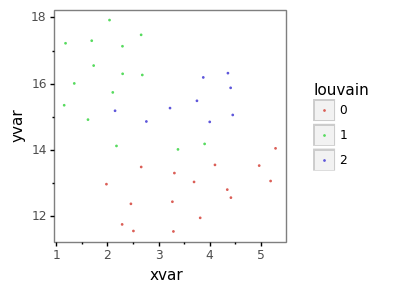

<ggplot: (8728992437245)>


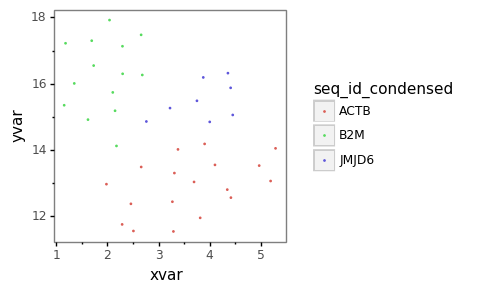

<ggplot: (8728992426977)>


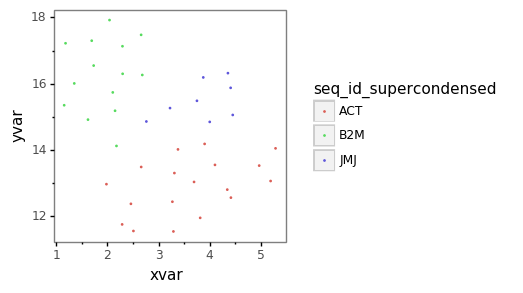

<ggplot: (8728992451276)>


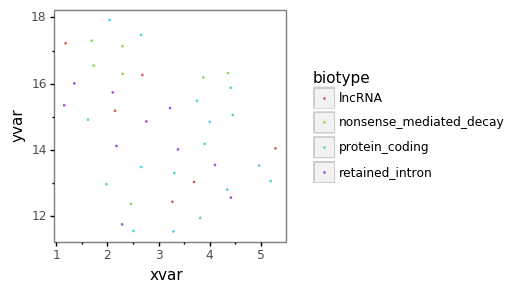

<ggplot: (8728992422327)>


In [13]:
louvain_res = 1
sc.tl.louvain(all_forms_adata, resolution = louvain_res, random_state=1)

umap_df = pd.DataFrame(all_forms_adata.obsm['X_umap'], columns = ['xvar','yvar'])
umap_df['cell_id'] = all_forms_adata.obs.cell_id.tolist()
umap_df['seq_id'] = all_forms_adata.obs.index.tolist()
umap_df['seq_id_condensed'] = [x.split('|')[-4] for x in umap_df['seq_id']]
umap_df['seq_id_supercondensed'] = [x[:3] for x in umap_df['seq_id_condensed']]
umap_df['biotype'] = [x.split('|')[-2] for x in umap_df['seq_id']]
umap_df['louvain'] = all_forms_adata.obs.louvain.tolist()

plotnine.options.figure_size = (3,3)
plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='louvain'), size=0.1)
       )
print(plot)

plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='seq_id_condensed'), size=0.1)
       )
print(plot)

plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='seq_id_supercondensed'), size=0.1)
       )
print(plot)

plot = (ggplot(umap_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='biotype'), size=0.1)
       )
print(plot)

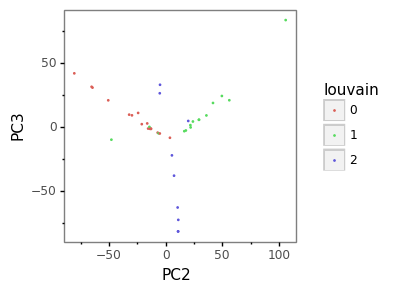

<ggplot: (8728992703580)>


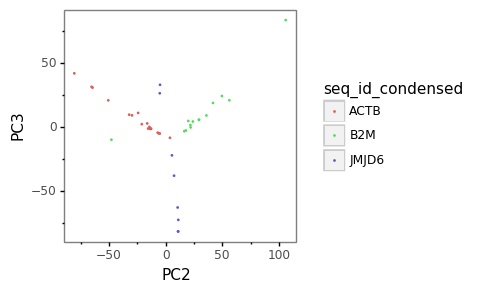

<ggplot: (-9223363307862322428)>


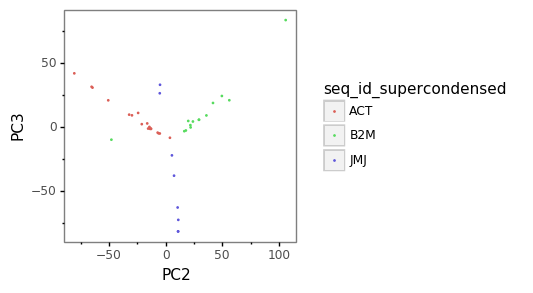

<ggplot: (8728992446945)>


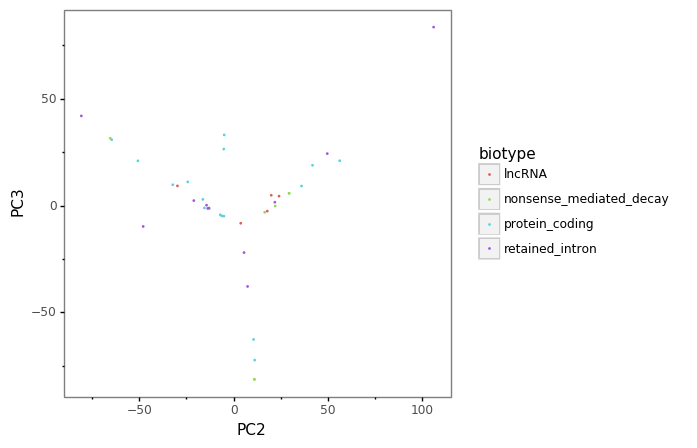

<ggplot: (8728992605339)>


In [20]:
pcx = 2
pcy = 3
pca_df = pd.DataFrame(all_forms_adata.obsm['X_pca'][:,[pcx, pcy]], columns = ['xvar','yvar'])
pca_df['cell_id'] = all_forms_adata.obs.cell_id.tolist()
pca_df['seq_id'] = all_forms_adata.obs.index.tolist()
pca_df['seq_id_condensed'] = [x.split('|')[-4] for x in pca_df['seq_id']]
pca_df['seq_id_supercondensed'] = [x[:3] for x in pca_df['seq_id_condensed']]
pca_df['biotype'] = [x.split('|')[-2] for x in pca_df['seq_id']]
pca_df['louvain'] = all_forms_adata.obs.louvain.tolist()
pca_df['marker_highlight'] = [x == 'markers' for x in pca_df['cell_id']]

plotnine.options.figure_size = (3,3)
plot = (ggplot(pca_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='louvain'), size=0.1)
        + labs(x=f'PC{pcx}', y=f'PC{pcy}')
       )
print(plot)

plot = (ggplot(pca_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='seq_id_condensed'), size=0.1)
        + labs(x=f'PC{pcx}', y=f'PC{pcy}')
       )
print(plot)

plot = (ggplot(pca_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='seq_id_supercondensed'), size=0.1)
        + labs(x=f'PC{pcx}', y=f'PC{pcy}')
       )
print(plot)

plot = (ggplot(pca_df)
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_grid_major = element_blank(), 
                panel_grid_minor = element_blank()
               )
        + geom_point(aes('xvar','yvar',color='biotype'), size=0.1)
        + labs(x=f'PC{pcx}', y=f'PC{pcy}')
       )
print(plot)